# Initial hit analysis

The purpose of this jupyter notebook is to analyze our initial hits

Hits are given in the format (spectrum_num, (m/z value, parent protein number, sequence, location in parent protein, ion, charge))

# Grabbing input data

In [1]:
import os
import sys
from typing import Tuple
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


import database, gen_spectra
import testing_utils

from constants import WATER_MASS, SINGLY_CHARGED_B_BASE, SINGLY_CHARGED_Y_BASE
from utils import ppm_to_da, overlap_intervals
from preprocessing import merge_search, preprocessing_utils
from collections import defaultdict
from objects import Spectrum

#Assumptions:
max_peptide_length = 20
ppm_tolerance = 20

import matplotlib.pyplot as plt

def collect_hit_or_miss_abundances(input_spectrum, mz_hit_set, correct_hits):
    hit_tuples = []
    miss_tuples = []
    correct_hit_tuples = []
    hit_set = set()
    
    [hit_set.add(x[2]) for x in mz_hit_set]
    for i, x in enumerate(input_spectrum[0]):
        if x in hit_set:
            hit_tuples.append((x, input_spectrum[1][i]))
            if x in correct_hits:
                correct_hit_tuples.append((x, input_spectrum[1][i]))
        else:
            miss_tuples.append((x, input_spectrum[1][i]))

    # pick apart tuples
    hit_list = []
    hit_abundances = []
    miss_list = []
    miss_abundances = []
    correct_hit_abundances = []
    c_hits = []
    
    for x in hit_tuples:
        hit_list.append(x[0])
        hit_abundances.append(x[1])
        
    for x in correct_hit_tuples:
        c_hits.append(x[0])
        correct_hit_abundances.append(x[1])
        
    for x in miss_tuples:
        miss_list.append(x[0])
        miss_abundances.append(x[1])
        
    return hit_list, hit_abundances, miss_list, miss_abundances, correct_hit_abundances, c_hits

In [2]:
datasets = testing_utils.define_data()

dataset = datasets[0]

input_spectra_path = dataset[0]
input_spectra, boundaries, mz_mapping = testing_utils.preprocess_input_spectra(input_spectra_path, ppm_tolerance)


correct_sequences = testing_utils.generate_truth_set(datasets[0])

# path = '/home/ncol107453/jaime_hypedsearch/hypedsearch/data/database/single_prot.fasta'
path = dataset[2]
db = database.build(path)

matched_masses_b, matched_masses_y, db = testing_utils.modified_match_masses(boundaries, db, max_peptide_length)
print('Finished matching masses')

Loading spectra...
Done
On batch 1/1
On protein 279/279 [100%]
Sorting the set of protein masses...
Done
Finished matching masses


# Preliminary analysis

* This is for the first spectrum in the NOD2_E3 database
* The correct sequence is "DPQVEQLEL"

    * First spectrum: [70.06548309326172, 84.04374694824219, 84.0806655883789, 86.09642028808594, 101.07074737548828, 102.05448913574219, 129.1007537841797, 132.10121154785156, 225.12210083007812, 226.1183624267578, 235.1075439453125, 243.13357543945312, 261.1429443359375, 341.1453857421875, 349.1622619628906, 358.1739196777344, 412.21746826171875, 440.216064453125, 569.2589721679688, 586.2818603515625, 697.3143310546875, 698.3234252929688, 810.3919677734375, 811.4014892578125, 939.4456176757812]
    * First abundance: [631.6238403320312, 1225.438232421875, 295.7095947265625, 6712.806640625, 1142.323486328125, 4010.84033203125, 282.75848388671875, 2225.234375, 286.7332458496094, 581.1842041015625, 341.5701904296875, 3202.428466796875, 308.77581787109375, 510.7484130859375, 324.578369140625, 272.275390625, 327.7127990722656, 498.826171875, 487.4165954589844, 559.4827880859375, 1858.8079833984375, 293.3522644042969, 1352.385986328125, 600.4566650390625, 491.5278625488281]
    
| mz | Abundance | Correct | Other matches? | Found in b_hits | Found in y_hits
| --- | --- | -- | -- | -- | -- |
| 70.06548309326172 | 631.6238403320312 | No | No | No | No |
| 84.04374694824219 | 1225.438232421875 | No | No | No| No |
| 84.0806655883789 | 295.7095947265625 | No | No | No | No |
| 86.09642028808594 | 6712.806640625 | No | No | No | No |
| 101.07074737548828 | 1142.323486328125 | No | No | No | No |
| 102.05448913574219 | 4010.84033203125 | No | Yes | Yes | Yes |
| 129.1007537841797 | 282.75848388671875 | No | Yes | Yes | No |
| 132.10121154785156 | 2225.234375 | Yes | Yes | No | Yes |
| 225.12210083007812 | 286.7332458496094 | No | Yes | Yes | Yes |
| 226.1183624267578 | 581.1842041015625 | No | Yes | Yes | Yes |
| 235.1075439453125 | 341.5701904296875 | No | Yes | Yes | Yes |
| 243.13357543945312 | 3202.428466796875 | No | Yes | Yes | Yes |
| 261.1429443359375 | 308.77581787109375 | Yes | Yes | Yes | Yes |
| 341.1453857421875 | 510.7484130859375 | Yes | Yes | Yes | Yes |
| 349.1622619628906 | 324.578369140625 | Yes | Yes | Yes | Yes |
| 358.1739196777344 | 272.275390625 | No | Yes | Yes | Yes |
| 412.21746826171875 | 327.7127990722656 | No | Yes | Yes | Yes |
| 440.216064453125 | 498.826171875 | Yes | Yes | Yes | Yes |
| 569.2589721679688 | 487.4165954589844 | Yes | Yes | Yes | Yes |
| 586.2818603515625 | 559.4827880859375 | No | Yes | Yes | Yes |
| 697.3143310546875 | 1858.8079833984375 | Yes | Yes | Yes | Yes |
| 698.3234252929688 | 293.3522644042969 | No | Yes | Yes | Yes |
| 810.3919677734375 | 1352.385986328125 | Yes | Yes | Yes | Yes |
| 811.4014892578125 | 600.4566650390625 | No | Yes | Yes | Yes |
| 939.4456176757812 | 491.5278625488281 | Yes | Yes | Yes | Yes |

* The other matches part being a "yes" past a certain point is completely expected as it becomes increasingly easier to find alignments with larger masses. I would expect more hits for larger masses

Text(0, 0.5, 'Abundance')

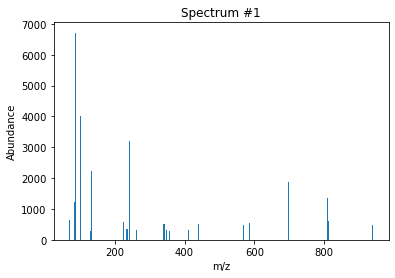

In [3]:
import matplotlib.pyplot as plt

first_spectrum = [70.06548309326172, 84.04374694824219, 84.0806655883789, 86.09642028808594, 101.07074737548828, 102.05448913574219, 129.1007537841797, 132.10121154785156, 225.12210083007812, 226.1183624267578, 235.1075439453125, 243.13357543945312, 261.1429443359375, 341.1453857421875, 349.1622619628906, 358.1739196777344, 412.21746826171875, 440.216064453125, 569.2589721679688, 586.2818603515625, 697.3143310546875, 698.3234252929688, 810.3919677734375, 811.4014892578125, 939.4456176757812]
first_abundance = [631.6238403320312, 1225.438232421875, 295.7095947265625, 6712.806640625, 1142.323486328125, 4010.84033203125, 282.75848388671875, 2225.234375, 286.7332458496094, 581.1842041015625, 341.5701904296875, 3202.428466796875, 308.77581787109375, 510.7484130859375, 324.578369140625, 272.275390625, 327.7127990722656, 498.826171875, 487.4165954589844, 559.4827880859375, 1858.8079833984375, 293.3522644042969, 1352.385986328125, 600.4566650390625, 491.5278625488281]
ideal_spectrum = [116.034219435, 213.08698343499998, 341.145561435, 440.213975435, 569.256568435, 697.315146435, 810.399210435, 939.441803435, 1052.525867435, 58.520747935, 107.047129935, 171.076418935, 220.610625935, 285.131922435, 349.161211435, 405.703243435, 470.224539935, 526.766571935, 132.101905135, 261.14449813500005, 374.22856213500006, 502.2871401350001, 631.3297331350001, 730.398147135, 858.456725135, 955.5094891350001, 1070.536432135, 66.554590785, 131.07588728500002, 187.61791928500003, 251.64720828500003, 316.16850478500004, 365.702711785, 429.732000785, 478.25838278500004, 535.771854285]

plt.bar(first_spectrum, first_abundance, width=3)
plt.title('Spectrum #1')
plt.xlabel('m/z')
plt.ylabel('Abundance')
# plt.plot(first_spectrum, first_abundance, markerfacecolor='r')

# Collecting initial hits

In [4]:
print('Starting mapping...')
correct_sequence = correct_sequences[0]

input_spectrum = input_spectra[0]

b_hits =[]
y_hits = []
b_set = set()
y_set = set()
correct_hits = []
mz_miss_set = set()
#Remember to add in abundance if it is helpful
input_num = 0
testing_utils.find_hits(mz_mapping, boundaries, input_spectrum, input_num, matched_masses_b, matched_masses_y, b_hits, y_hits, b_set, y_set, mz_miss_set)
testing_utils.append_correct_hits(correct_hits, correct_sequence, input_spectrum, ppm_tolerance)
print('Done')

#Writing b and y hits
print('Writing data...')
with open("b_hits.txt", 'w') as b:
    for x in b_hits:
        pep_id = x[0]
        w = x[1][0]
        prot_id = x[1][1]
        seq = x[1][2]
        loc = x[1][3]
        ion = x[1][4]
        charge = x[1][5]
        out = [pep_id, w, prot_id, seq, loc, ion, charge]
        b.write('\t'.join([str(i) for i in out]) + '\n')
with open("y_hits.txt", 'w') as y_file:
    for y in y_hits:
        pep_id = y[0]
        w = y[1][0]
        prot_id = y[1][1]
        seq = y[1][2]
        loc = y[1][3]
        ion = y[1][4]
        charge = y[1][5]
        out = [pep_id, w, prot_id, seq, loc, ion, charge]
        y_file.write('\t'.join([str(i) for i in out]) + '\n')
print('Done')

Starting mapping...
Done
Writing data...
Done


# Printing b hits

In [5]:
print(len(b_hits))
print(b_hits)

31360
[(0, (102.054955435, 125, 'T', '13-13', 'b', 1)), (0, (102.054955435, 191, 'T', '1448-1448', 'b', 1)), (0, (102.054955435, 137, 'T', '822-822', 'b', 1)), (0, (102.054955435, 79, 'T', '191-191', 'b', 1)), (0, (102.054955435, 171, 'T', '252-252', 'b', 1)), (0, (102.054955435, 249, 'T', '461-461', 'b', 1)), (0, (102.054955435, 271, 'T', '174-174', 'b', 1)), (0, (102.054955435, 265, 'T', '59-59', 'b', 1)), (0, (102.054955435, 70, 'T', '132-132', 'b', 1)), (0, (102.054955435, 249, 'T', '444-444', 'b', 1)), (0, (102.054955435, 13, 'T', '85-85', 'b', 1)), (0, (102.054955435, 63, 'T', '32-32', 'b', 1)), (0, (102.054955435, 249, 'T', '442-442', 'b', 1)), (0, (102.054955435, 40, 'T', '13-13', 'b', 1)), (0, (102.054955435, 156, 'T', '365-365', 'b', 1)), (0, (102.054955435, 157, 'T', '361-361', 'b', 1)), (0, (102.054955435, 194, 'T', '190-190', 'b', 1)), (0, (102.054955435, 137, 'T', '150-150', 'b', 1)), (0, (102.054955435, 202, 'T', '470-470', 'b', 1)), (0, (102.054955435, 64, 'T', '63-63',

# Printing y_hits

In [6]:
print(len(y_hits))
print(y_hits)

30675
[(0, (102.05495478499999, 149, 'SP', '707-708', 'y', 2)), (0, (102.05495478499999, 13, 'PS', '867-868', 'y', 2)), (0, (102.05495478499999, 129, 'SP', '1463-1464', 'y', 2)), (0, (102.05495478499999, 210, 'PS', '48-49', 'y', 2)), (0, (102.05495478499999, 137, 'SP', '3446-3447', 'y', 2)), (0, (102.05495478499999, 36, 'PS', '133-134', 'y', 2)), (0, (102.05495478499999, 13, 'SP', '866-867', 'y', 2)), (0, (102.05495478499999, 16, 'SP', '449-450', 'y', 2)), (0, (102.05495478499999, 60, 'SP', '14-15', 'y', 2)), (0, (102.05495478499999, 76, 'PS', '1481-1482', 'y', 2)), (0, (102.05495478499999, 241, 'SP', '33-34', 'y', 2)), (0, (102.05495478499999, 57, 'PS', '75-76', 'y', 2)), (0, (102.05495478499999, 234, 'PS', '80-81', 'y', 2)), (0, (102.05495478499999, 44, 'SP', '67-68', 'y', 2)), (0, (102.05495478499999, 204, 'PS', '32-33', 'y', 2)), (0, (102.05495478499999, 83, 'PS', '214-215', 'y', 2)), (0, (102.05495478499999, 172, 'PS', '67-68', 'y', 2)), (0, (102.05495478499999, 254, 'SP', '748-74

# Printing number of hits

In [7]:
all_hit_set = b_set | y_set
print('Total number of hits:', len(all_hit_set), 'out of', len(input_spectrum[0]), 'total mz values', '(' + str(round((len(all_hit_set) / len(input_spectrum[0]) * 100))) + '%)')
print('Total number of misses:', len(mz_miss_set), 'out of', len(input_spectrum[0]), 'total mz values', '(' + str(round((len(mz_miss_set) / len(input_spectrum[0]) * 100))) + '%)')
print('Num b hits:', len(b_set))
print('Num y hits:', len(y_set))

Total number of hits: 20 out of 25 total mz values (80%)
Total number of misses: 5 out of 25 total mz values (20%)
Num b hits: 19
Num y hits: 19


# Printing number of correct hits

In [8]:
print('Total number of correct hits:', len(correct_hits), 'out of', len(input_spectrum[0]), 'total mz values', '(' + str(round((len(correct_hits) / len(input_spectrum[0]) * 100))) + '%)')

Total number of correct hits: 9 out of 25 total mz values (36%)


# Comparing abundance of a hit to that of a miss

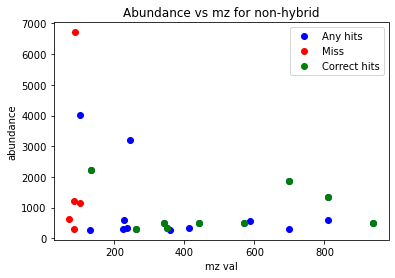

In [9]:
hit_list, hit_abundances, miss_list, miss_abundances, correct_hit_abundances, c_hits = collect_hit_or_miss_abundances(input_spectrum, all_hit_set, correct_hits)

plt.xlabel('mz val')
plt.ylabel('abundance')
plt.title('Abundance vs mz for non-hybrid')
plt.plot(hit_list, hit_abundances, 'bo', label='Any hits')
plt.plot(miss_list, miss_abundances, 'ro', label='Miss')
plt.plot(c_hits, correct_hit_abundances, 'go', label='Correct hits')
plt.legend()

# Analysis of a hybrid

* Perform the same analysis of a hybrid spectrum
* Chose the 5th spectrum
* Correct answer is "DLQTLAL-LL"

In [10]:
print('Starting mapping...')
correct_sequence = correct_sequences[4]

input_spectrum = input_spectra[4]

b_hits =[]
y_hits = []
b_set = set()
y_set = set()
correct_hits = []
mz_miss_set = set()
#Remember to add in abundance if it is helpful
input_num = 4
testing_utils.find_hits(mz_mapping, boundaries, input_spectrum, input_num, matched_masses_b, matched_masses_y, b_hits, y_hits, b_set, y_set, mz_miss_set)
testing_utils.append_correct_hits(correct_hits, correct_sequence, input_spectrum, ppm_tolerance)
print('Done')

#Writing b and y hits
print('Writing data...')
with open("b_hits.txt", 'w') as b:
    for x in b_hits:
        pep_id = x[0]
        w = x[1][0]
        prot_id = x[1][1]
        seq = x[1][2]
        loc = x[1][3]
        ion = x[1][4]
        charge = x[1][5]
        out = [pep_id, w, prot_id, seq, loc, ion, charge]
        b.write('\t'.join([str(i) for i in out]) + '\n')
with open("y_hits.txt", 'w') as y_file:
    for y in y_hits:
        pep_id = y[0]
        w = y[1][0]
        prot_id = y[1][1]
        seq = y[1][2]
        loc = y[1][3]
        ion = y[1][4]
        charge = y[1][5]
        out = [pep_id, w, prot_id, seq, loc, ion, charge]
        y_file.write('\t'.join([str(i) for i in out]) + '\n')
print('Done')

Starting mapping...
Done
Writing data...
Done


# Printing b hits

In [11]:
print(len(b_hits))

29347


# Printing y hits

In [12]:
print(len(y_hits))

29212


# Calculating number of mz which landed a hit

In [15]:
all_hit_set = b_set | y_set
print('Total number of hits:', len(mz_hit_set), 'out of', len(input_spectrum[0]), 'total mz values', '(' + str(round((len(mz_hit_set) / len(input_spectrum[0]) * 100))) + '%)')
print('Total number of misses:', len(mz_miss_set), 'out of', len(input_spectrum[0]), 'total mz values', '(' + str(round((len(mz_miss_set) / len(input_spectrum[0]) * 100))) + '%)')
print('Num b hits:', len(b_set))
print('Num y hits:', len(y_set))

Total number of hits: 21 out of 25 total mz values (84%)
Total number of misses: 4 out of 25 total mz values (16%)
Num b hits: 19
Num y hits: 19


# Calculating number of correct hits

In [16]:
print('Total number of correct hits:', len(correct_hits), 'out of', len(input_spectrum[0]), 'total mz values', '(' + str(round((len(correct_hits) / len(input_spectrum[0]) * 100))) + '%)')

Total number of correct hits: 8 out of 25 total mz values (32%)


# Comparing abundance of a hit to that of a miss

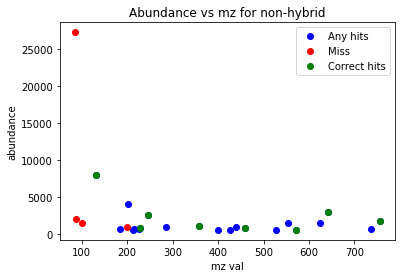

In [17]:
hit_list, hit_abundances, miss_list, miss_abundances, correct_hit_abundances, c_hits = collect_hit_or_miss_abundances(input_spectrum, all_hit_set, correct_hits)

plt.xlabel('mz val')
plt.ylabel('abundance')
plt.title('Abundance vs mz for non-hybrid')
plt.plot(hit_list, hit_abundances, 'bo', label='Any hits')
plt.plot(miss_list, miss_abundances, 'ro', label='Miss')
plt.plot(c_hits, correct_hit_abundances, 'go', label='Correct hits')
plt.legend()

# Running on entire dataset

# Getting input data

In [18]:
print('Starting mapping...')
b_hits =[]
y_hits = []
b_set = set()
y_set = set()
correct_hits = []
mz_miss_set = set()
for i, spectrum in enumerate(input_spectra):
    #Remember to add in abundance if it is helpful
    correct_sequence = correct_sequences[i]
    testing_utils.find_hits(mz_mapping, boundaries, spectrum, i, matched_masses_b, matched_masses_y, b_hits, y_hits, b_set, y_set, mz_miss_set)
    testing_utils.append_correct_hits(correct_hits, correct_sequence, spectrum, ppm_tolerance)
print('Done')

#Writing b and y hits
print('Writing data...')
with open("b_hits.txt", 'w') as b:
    for x in b_hits:
        pep_id = x[0]
        w = x[1][0]
        prot_id = x[1][1]
        seq = x[1][2]
        loc = x[1][3]
        ion = x[1][4]
        charge = x[1][5]
        out = [pep_id, w, prot_id, seq, loc, ion, charge]
        b.write('\t'.join([str(i) for i in out]) + '\n')
with open("y_hits.txt", 'w') as y_file:
    for y in y_hits:
        pep_id = y[0]
        w = y[1][0]
        prot_id = y[1][1]
        seq = y[1][2]
        loc = y[1][3]
        ion = y[1][4]
        charge = y[1][5]
        out = [pep_id, w, prot_id, seq, loc, ion, charge]
        y_file.write('\t'.join([str(i) for i in out]) + '\n')
print('Done')


Starting mapping...
Done
Writing data...
Done


# Print new b_hits

In [19]:
print(len(b_hits))

25426421


# Print new y_hits

In [20]:
print(len(y_hits))

19576189


# Printing number of hits

In [21]:
# Calculating total length
total_len = 0
for spectrum in input_spectra:
    total_len = total_len + len(spectrum[0])
mz_hit_set = b_set | y_set
    
print('Total number of hits:', len(mz_hit_set), 'out of', total_len, 'total mz values', '(' + str(round((len(mz_hit_set) / total_len * 100))) + '%)')
print('Total number of misses:', len(mz_miss_set), 'out of', total_len, 'total mz values', '(' + str(round((len(mz_miss_set) / total_len * 100))) + '%)')
print('Num b hits:', len(b_set))
print('Num y hits:', len(y_set))
print(len(mz_hit_set) + len(mz_miss_set))

Total number of hits: 21104 out of 27150 total mz values (78%)
Total number of misses: 6046 out of 27150 total mz values (22%)
Num b hits: 19877
Num y hits: 19508
27150


# Collecting correct hits

In [22]:
print('Total number of correct hits:', len(correct_hits), 'out of', total_len, 'total mz values', '(' + str(round((len(correct_hits) / total_len * 100))) + '%)')

Total number of correct hits: 8037 out of 27150 total mz values (30%)


# Comparing abundances of hit vs abundance of miss

In [23]:
combined_hit_list = []
combined_hit_abundance_list = []
combined_miss_list = []
combined_miss_abundances = []
combined_correct_hits = []
combined_correct_hit_abundances = []

print('')
for spectrum in input_spectra: 
    hit_list, hit_abundances, miss_list, miss_abundances, correct_hit_abundances, c_hits = collect_hit_or_miss_abundances(spectrum, mz_hit_set, correct_hits)

    [combined_hit_list.append(x) for x in hit_list]
    [combined_hit_abundance_list.append(x) for x in hit_abundances]
    [combined_miss_list.append(x) for x in miss_list]
    [combined_miss_abundances.append(x) for x in miss_abundances]
    [combined_correct_hits.append(x) for x in c_hits]
    [combined_correct_hit_abundances.append(x) for x in correct_hit_abundances]
    

print(len(combined_hit_list))
print(len(combined_hit_abundance_list))
print(len(combined_miss_list))
print(len(combined_miss_abundances))
print(len(combined_correct_hits))
print(len(combined_correct_hit_abundances))


21104
21104
6046
6046
8110
8110


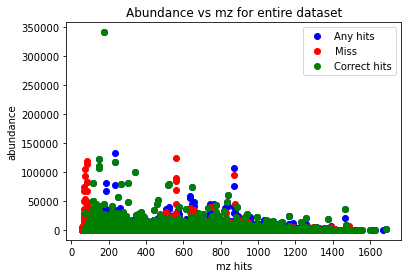

In [24]:
plt.xlabel('mz hits')
plt.ylabel('abundance')
plt.title('Abundance vs mz for entire dataset')
plt.plot(combined_hit_list, combined_hit_abundance_list, 'bo', label='Any hits')
plt.plot(combined_miss_list, combined_miss_abundances, 'ro', label='Miss')
plt.plot(combined_correct_hits, combined_correct_hit_abundances, 'go', label='Correct hits')
plt.legend()

In [25]:
union = b_set | y_set
print(len(union), len(b_set), len(y_set))

print('There are', total_len - len(union) - len(mz_miss_set), 'missing masses')

21104 19877 19508
There are 0 missing masses


# Debugging missing hits

In [26]:
# Combine all mz values, see how many match another mz value in the list
combined_mz = []
for spectrum in input_spectra:
    spectrum_mz = spectrum[0]
    [combined_mz.append(mz) for mz in spectrum_mz]
print(len(combined_mz))

def checkIfDuplicates_1(listOfElems):
    ''' Check if given list contains any duplicates '''
    if len(listOfElems) == len(set(listOfElems)):
        return False
    else:
        return True
    
print(checkIfDuplicates_1(combined_mz))
print('There are', len(combined_mz) - len(set(combined_mz)), "duplicates")

# Now give each mz a tag according to spectrum num and their mz position
combined_tagged_mz = []
for spectrum in input_spectra:
    spectrum_mz = spectrum[0]
    [combined_tagged_mz.append((i, mz)) for i, mz in enumerate(spectrum_mz)]

print(checkIfDuplicates_1(combined_tagged_mz))
print('There are', len(combined_tagged_mz) - len(set(combined_tagged_mz)), "duplicates")

# Now give each mz a different tag with spectrum number, mz number, and mz_value. There should be no duplicates now
refined_tagged_mz = []
for i, spectrum in enumerate(input_spectra):
    spectrum_mz = spectrum[0]
    [refined_tagged_mz.append((i,j,mz)) for j, mz in enumerate(spectrum_mz)]
    
print(checkIfDuplicates_1(refined_tagged_mz))
print('There are', len(refined_tagged_mz) - len(set(refined_tagged_mz)), "duplicates")

27150
True
There are 2991 duplicates
True
There are 1179 duplicates
False
There are 0 duplicates
